<a href="https://colab.research.google.com/github/vaibhav-rj/vaibhav-rj/blob/master/deal_sent_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip3 install transformers

     |████████████████████████████████| 481kB 10.2MB/s 
     |████████████████████████████████| 3.1MB 75.5MB/s 
     |████████████████████████████████| 870kB 62.6MB/s 
     |████████████████████████████████| 1.0MB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=de713faf80304f61458b4887fcf323f2f1e2ab0c835faa515d282296be2a6c15
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Team restricted/Colab Notebooks/deal_data.csv")
#df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/deal_data .csv")
#df = pd.read_csv(uploaded['deal_data .csv'])
df.tail()

ls=[]
for i in range(df['link'].count()):
    d=dict(df.iloc[i])
    d['ID']='id'+str(i).zfill(4)
    ls.append(d)
    #count+=1

df1=pd.DataFrame(ls)
df1.tail()

# Creating train dataframe according to BERT
#df_bert_train = pd.DataFrame({'id':df1['ID'], 'label':df1['LABEL'], 'alpha':['a']*df1.shape[0], 'sentence':df1['SENTENCE'].replace(r'\n',' ',regex=True)})
df_bert_train_one = df1[(df1['LABEL'] == 1) & (df1['SENTENCE'].str.len() <512)]
df_bert_train_zero = df1[(df1['LABEL'] == 0) & (df1['SENTENCE'].str.len() <512)]
#df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)


In [ ]:
df_bert_train_zero.count()

link          866
SENTENCE      866
LABEL         866
Unnamed: 3      0
ID            866
dtype: int64

In [ ]:
df_bert_train_one.count()

link          437
SENTENCE      437
LABEL         437
Unnamed: 3      1
ID            437
dtype: int64

In [ ]:
df_bert_train =[]
for i in range(df_bert_train_zero['link'].count()//2):
  j = 2*i
  df_bert_train.append(dict(df_bert_train_one.iloc[i]) )

  [df_bert_train.append(dict(df_bert_train_zero.iloc[k])) for k in range(j,j+2)]

df_bert_train = pd.DataFrame(df_bert_train)



In [ ]:
df_bert_train.count()

link          1299
SENTENCE      1299
LABEL         1299
Unnamed: 3       1
ID            1299
dtype: int64

In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df_bert_train.head(9)

Number of training sentences: 1,390



,link,SENTENCE,LABEL,Unnamed: 3,ID
0,http://www.fiercepharma.com/pharma/doj-s-price...,"Allergan, which sold its generics division to ...",1,NaN,id0000
1,http://www.fiercepharma.com/pharma/pfizer-cons...,"According to a Reuters exclusive, unnamed sour...",0,NaN,id0003
2,http://www.fiercepharma.com/pharma/pfizer-cons...,Take out charges for acquisitions and other on...,0,NaN,id0004
3,http://www.fiercepharma.com/pharma/pfizer-cons...,Merck ($MRK) sold its consumer health unit in ...,1,NaN,id0001
4,http://www.fiercepharma.com/pharma/valeant-sla...,Valeant reported that its revenues during the ...,0,NaN,id0006
5,http://www.fiercepharma.com/pharma/valeant-sla...,The dire report sent some analysts on a search...,0,NaN,id0007
6,http://www.fiercepharma.com/pharma/pfizer-cons...,"But the unit drew a lot of interest, and Bayer...",1,NaN,id0002
7,http://www.fiercepharma.com/pharma/regeneron-s...,But Regeneron’s collaboration with French phar...,0,NaN,id0010
8,http://www.fiercepharma.com/marketing/former-s...,"To make sure they're not shortchanged, they’re...",0,NaN,id0013


In [ ]:
# Get the lists of sentences and their labels.
sentences = df_bert_train.SENTENCE.values
labels = df_bert_train.LABEL.values
print(labels)

[1 0 0 ... 1 0 0]


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Allergan, which sold its generics division to Teva for $40.5 billion
Tokenized:  ['all', '##er', '##gan', ',', 'which', 'sold', 'its', 'generic', '##s', 'division', 'to', 'te', '##va', 'for', '$', '40', '.', '5', 'billion']
Token IDs:  [2035, 2121, 5289, 1010, 2029, 2853, 2049, 12391, 2015, 2407, 2000, 8915, 3567, 2005, 1002, 2871, 1012, 1019, 4551]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Allergan, which sold its generics division to Teva for $40.5 billion
Token IDs: [101, 2035, 2121, 5289, 1010, 2029, 2853, 2049, 12391, 2015, 2407, 2000, 8915, 3567, 2005, 1002, 2871, 1012, 1019, 4551, 102]


In [ ]:
print(len(input_ids[0]))

21


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  135


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


In [ ]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Allergan, which sold its generics division to Teva for $40.5 billion
Token IDs: [  101  2035  2121  5289  1010  2029  2853  2049 12391  2015  2407  2000
  8915  3567  2005  1002  2871  1012  1019  4551   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   

In [ ]:
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
print('Original: ', sentences[0])
print('Attention_masks: ', attention_masks[0])

Original:  Allergan, which sold its generics division to Teva for $40.5 billion
Attention_masks:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 30

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

model.zero_grad()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
        
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Put the model into training mode.    
        model.train()

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
                
        # Forward pass (evaluate the model on this training batch)
        # `model` is of type: pytorch_pretrained_bert.modeling.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        # Accumulate the loss. `loss` is a Tensor containing a single value; 
        # the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Clear out the gradients (by default they accumulate)
        model.zero_grad()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions
            # token_type_ids is for the segment ids, but we only have a single sentence here.
            # See https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L258 
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.58
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.31
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.25
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:01

Training complete!


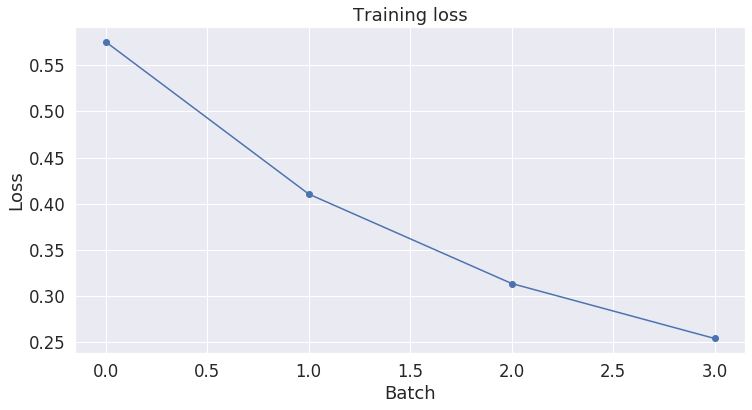

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df1 = pd.read_csv("/content/drive/My Drive/Team restricted/Colab Notebooks/deal_val_data.csv")

df1_test = df1.to_dict('records')
#print(df1_test)

for i1 in range(433,df_bert_train_one['link'].count()):
  df1_test.append(dict(df_bert_train_one.iloc[i1]) )

df1_test = pd.DataFrame(df1_test)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df1_test.shape[0]))

df1_test.head(14)

#Creating the sentences and label lists
sentences = df1_test.SENTENCE.values
labels = df1_test.LABEL.values

Number of test sentences: 14



In [ ]:


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 30  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 14 test sentences...
    DONE.


In [ ]:
print(predictions)
print('-'*50)
print(true_labels)

[array([[-0.7572932 ,  0.3067823 ],
       [ 0.87203777, -0.6979471 ],
       [-1.25568   ,  0.79015476],
       [-1.3608772 ,  0.79104084],
       [-1.1120173 ,  0.43329406],
       [ 0.9183744 , -0.7639485 ],
       [ 1.2653387 , -0.90076286],
       [ 0.5037765 , -0.4165206 ],
       [-1.5173577 ,  0.8754852 ],
       [ 1.6887057 , -1.2414652 ],
       [-1.4310074 ,  0.8331612 ],
       [-1.3179945 ,  0.8135978 ],
       [-1.4408678 ,  0.92706996],
       [-0.7572932 ,  0.3067823 ]], dtype=float32)]
--------------------------------------------------
[array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1])]


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df1_test.LABEL.sum(), len(df1_test.LABEL), (df1_test.LABEL.sum() / len(df1_test.LABEL) * 100.0)))

Positive samples: 9 of 14 (64.29%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  print(pred_labels_i)
  print('-'*50)
  print(true_labels[i])
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
[1 0 1 1 1 0 0 0 1 0 1 1 1 1]
--------------------------------------------------
[1 0 1 0 1 1 0 0 1 0 1 1 1 1]


In [ ]:
matthews_set

[0.6888888888888889]

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.689


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save1/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save1/


('./model_save1/vocab.txt',
 './model_save1/special_tokens_map.json',
 './model_save1/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save1/

total 427968K
-rw-r--r-- 1 root root      1K Jan 31 05:41 added_tokens.json
-rw-r--r-- 1 root root      1K Jan 31 05:41 config.json
-rw-r--r-- 1 root root 427719K Jan 31 05:41 pytorch_model.bin
-rw-r--r-- 1 root root      1K Jan 31 05:41 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jan 31 05:41 tokenizer_config.json
-rw-r--r-- 1 root root    227K Jan 31 05:41 vocab.txt


In [ ]:
!ls -l --block-size=M ./model_save1/pytorch_model.bin

-rw-r--r-- 1 root root 418M Jan 31 05:41 ./model_save1/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save1/ "./drive/My Drive/Team restricted/Colab Notebooks"

In [ ]:
from transformers import BertModel
from transformers import BertTokenizer

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertModel.from_pretrained('/content/drive/My Drive/Team restricted/Colab Notebooks/model_save1')
tokenizer = BertTokenizer.from_pretrained('/content/drive/My Drive/Team restricted/Colab Notebooks/model_save1')

# Copy the model to the GPU.
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
